In [1]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import time
from datetime import datetime
import inspect
from utils.constants import *
from datetime import datetime
import math
import statistics
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from pathlib import Path
from scipy.stats import norm, mannwhitneyu
import statistics


In [2]:
# CONFIGURATION
min_temp = 0
max_temp = 200

min_battery = 40
max_battery = 80

between = 0
duration = 1

special_between = {
    WINDOWS_OS : {
        CLAMP : 1,
        E3 : 2
    }
}

language = "CSharp"

env = "PROD"

limit = 200

In [3]:
## OS
oses = [
    WINDOWS_OS,
    LINUX_OS
]

short_os = {
    WINDOWS_OS : "win",
    LINUX_OS : "lin"
}

In [4]:
## Test cases
test_cases = [
    IDLE_CASE,
    # DINING_PHILOSOPHERS,
    BINARY_TREE,
    # REVERSE_COMPLEMENT
    FANNKUCH_REDUX,
    NBODY,
    FASTA
]

short_test_case = {
    IDLE_CASE : "idle",
    DINING_PHILOSOPHERS : "din",
    BINARY_TREE : "bin",
    REVERSE_COMPLEMENT : "rev",
    FANNKUCH_REDUX : "fann",
    NBODY : "nbody",
    FASTA : "fasta"
}

In [5]:
## Profilers
profilers = [
    INTEL_POWER_GADGET,
    RAPL,
    HARDWARE_MONITOR,
    CLAMP,
    #E3
]

short_profilers = {
    INTEL_POWER_GADGET : "IPG",
    RAPL : "RA",
    HARDWARE_MONITOR : "HWM",
    E3 : "E3",
    CLAMP : "CL"
}

In [6]:
## DUT
duts = [
    SURFACE_4_PRO,
    SURFACE_BOOK,
    POWER_KOMPLETT
]

short_duts = {
    SURFACE_4_PRO : "pro",
    SURFACE_BOOK : "book",
    POWER_KOMPLETT : "pow",
}

dut_version = {
    SURFACE_BOOK : {
            WINDOWS_OS : 6,
            LINUX_OS : 3
        },
    SURFACE_4_PRO : {
        WINDOWS_OS : 12,
        LINUX_OS : 2,
    },
    POWER_KOMPLETT : {
        WINDOWS_OS : 8,#9
        LINUX_OS : 1,#3
    }
}

In [7]:
comparison_types = [PACKAGE_TOTAL, DRAM_TOTAL,CORE_TOTAL]

In [8]:
# repository = DataRepository()

# data = repository.get_experiments(
#         duts,
#         oses,
#         test_cases,
#         profilers,
#         dut_version,
#         min_temp,
#         max_temp,
#         min_battery,
#         max_battery,
#         duration,
#         between,
#         env,
#         language,
#         special_between
#     )

# repository.close()
# %store data

In [9]:
%store -r

In [10]:
data.keys()
data['PowerKomplett'].keys()
data['PowerKomplett']['Win32NT'].keys()
# data['PowerKomplett']['Win32NT']['TestCaseIdle'].keys()
# data['PowerKomplett']['Win32NT']['TestCaseIdle']['IntelPowerGadget'].keys()
# experiment = data['PowerKomplett']['Win32NT']['TestCaseIdle']['IntelPowerGadget']['experiment']
# for e in experiment.experiments:
#     print(e.CumulativeProcessorEnergyInJoules)


dict_keys(['TestCaseIdle', 'BinaryTrees', 'FannkuchRedux', 'Nbody', 'Fasta'])

In [11]:
class ExpDataPoint(object):
    def __init__(self, exp_id, consumption, runs, duration):
        self.exp_id = exp_id
        self.x = consumption/ runs
        self.y = duration / runs
    
    def set_id(self, id):
        self.id = id
    
    def get_tuple(self):
        return (self.x, self.y)

    def set_distance_to_k(self, value):
        self.dist = value

def find_outliers(experiments, k, points_to_look_back, profiler, y_max, y_min, x_min, x_max, use_x_lim, use_y_lim, min_sampels=4, show_graphs=False):
    exp_data_points = [] #here 

    for e in experiments:
        if profiler == INTEL_POWER_GADGET:
            power = e.CumulativeProcessorEnergyInJoules
        elif profiler == HARDWARE_MONITOR:
            power = e.cpuPowerPacketTotalJ
        elif profiler == RAPL:
            power = e.CoreStopInJoules - e.CoreStartInJoules
        elif profiler == CLAMP:
            power = e.TrueRMS
        else:
            raise Exception("profiler not implemented") ## ipg CumulativeProcessorEnergyInJoules, TrueRMS, x.CoreStopInJoules - x.CoreStartInJoules
        
        exp_data_points.append(ExpDataPoint(
            e.id, power, e.runs, e.duration
        ))
    
    # if show_graphs:
    #     plt.scatter(*zip(*(x.get_tuple() for x in exp_data_points)))
    #     plt.show()
    
    for p1 in exp_data_points:
        dists = []
        for p2 in exp_data_points:
            if p1.exp_id == p2.exp_id:
                dists.append(math.inf)
            else:
                dists.append(math.dist(p1.get_tuple(), p2.get_tuple()))
        sorted_by_second = sorted(dists, key=lambda tup: tup)
        p1.set_distance_to_k(sorted_by_second[k])
    
    exp_data_points = sorted(exp_data_points, key=lambda tup: tup.dist)
    
    for i in range(len(exp_data_points)):
        exp_data_points[i].set_id(i)

    if show_graphs:
        plt.scatter(*zip(*((x.id, x.dist) for x in exp_data_points)))

        plt.show()
    
    eps = exp_data_points[-points_to_look_back].dist
    min_sampels = 4
    
    data_arr = np.array([x.get_tuple() for x in exp_data_points])
    
    dbscan = DBSCAN(eps = eps, min_samples = min_sampels)
    pred = dbscan.fit_predict(data_arr)
    anom_index = np.where(pred == -1)
    values = data_arr[anom_index]

    if show_graphs:
        plt.scatter(data_arr[:,0], data_arr[:,1])
        plt.scatter(values[:,0], values[:,1], color='r')
        if use_x_lim:
            plt.xlim(x_min, x_max)
        if use_y_lim:
            plt.ylim(y_min,y_max)
        plt.show()

    points_to_remove = []

    for v in values:
        for e in exp_data_points:
            tup = (v[0], v[1])
            
            if tup == e.get_tuple():
                points_to_remove.append(e)
                break

    #print(f"{len(points_to_remove)} points were removed")
                
    # for p in points_to_remove:
    #     print(f"{p.exp_id} - {p.get_tuple()}")
    
    return [x.exp_id for x in points_to_remove]
    

In [12]:
data[SURFACE_4_PRO][WINDOWS_OS][IDLE_CASE][INTEL_POWER_GADGET]["contains_data"] #here


True

In [13]:
for d in duts: #here
    for o in oses:
        for t in test_cases:
            for p in profilers:
                if data[d][o][t][p]["contains_data"]:
                    ee = data[d][o][t][p]["experiment"]
                    removed_points = find_outliers(ee.experiments, ee.k, ee.look_back, p, 0, 0, 0, 0, False, False, min_sampels=4, show_graphs=False)
                    
                    for e in ee.experiments:
                        if e.id in removed_points:
                            e.is_outlier = True
                        else:
                            e.is_outlier = False

In [14]:
def GetData(experiments, profiler, raw = False):
    stuff = []
    for e in experiments:
        if(not raw):
            r = e.runs
        else:
            r = 1 

        if profiler == INTEL_POWER_GADGET:
            power = e.CumulativeProcessorEnergyInJoules/r
        elif profiler == HARDWARE_MONITOR:
            power = e.cpuPowerPacketTotalJ/r
        elif profiler == RAPL:
            power = (e.CoreStopInJoules - e.CoreStartInJoules)/r
        elif profiler == CLAMP:
            power = e.TrueRMS/r
        else:
            raise Exception("profiler not implemented") ## ipg CumulativeProcessorEnergyInJoules, TrueRMS, x.CoreStopInJoules - x.CoreStartInJoules
        stuff.append(power)  
    return stuff

### Testing for normal distribution (Sharpiro Wilk)

In [15]:
from scipy import stats
def NormDist(experiments, pval, profiler):
    data = GetData(experiments,profiler)
    shapiro_test = stats.shapiro(data)
    if(shapiro_test.pvalue <= pval):
        return (True,shapiro_test.pvalue)
    else:
        return (False,shapiro_test.pvalue)     

In [16]:
def PlotNormalDist(data,p):
    NumData = GetData(data,p)

    NumData.sort()
    NumData = NumData[:-2]
    mu, std = norm.fit(NumData) 


    plt.hist(NumData, bins=5, density=True, alpha=0.6, color='b')
    # plt.ylabel('some numbers')
    # plt.show()
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    
    plt.show()

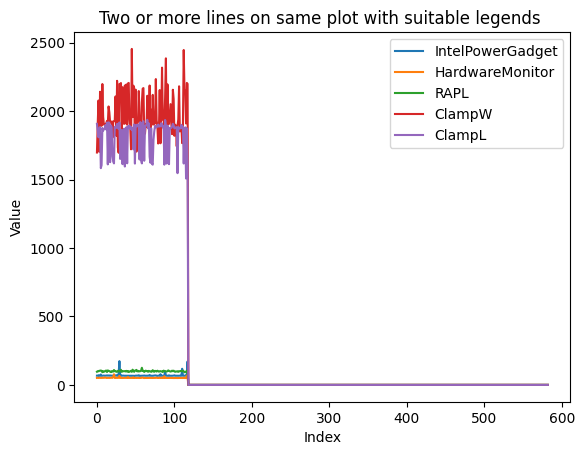

\begin{figure}\centering\begin{tikzpicture}[]
            \begin{axis}[ymax=120,
            xlabel={Index},
            ylabel={Energy Consumption (Joules)},
            ]\addplot[color=blue, mark=none,] coordinates {(0,67.484315)(1,67.17346)(2,70.9758)(3,66.58557)(4,66.966645)(5,76.21213)(6,66.52994)(7,67.171355)(8,68.05536)(9,68.48517)(10,67.055575)(11,67.852905)(12,67.822875)(13,69.630675)(14,67.70163)(15,69.0661)(16,67.37375)(17,69.3129)(18,67.51999)(19,67.776825)(20,66.88736)(21,66.742765)(22,70.498655)(23,68.483825)(24,68.333315)(25,71.16266)(26,67.58676)(27,66.819975)(28,80.780365)(29,173.815885)(30,66.87015)(31,70.82245)(32,67.26605)(33,67.947845)(34,68.159485)(35,67.20108)(36,67.1861)(37,67.681275)(38,66.754485)(39,67.776)(40,66.47647)(41,67.91855)(42,66.321625)(43,67.493685)(44,67.06952)(45,66.67563)(46,67.173645)(47,66.759615)(48,65.643555)(49,66.6561)(50,67.70331)(51,67.774015)(52,67.21512)(53,68.101045)(54,70.490965)(55,66.30136)(56,66.71393)(57,67.2879)(58,67.01898)(59,6

In [79]:
# lst = ['IntelPowerGadget Surface4Pro', 'HardwareMonitor Surface4Pro',
#         'RAPL Surface4Pro', 'IntelPowerGadget SurfaceBook', 
#         'HardwareMonitor SurfaceBook', 'RAPL SurfaceBook', 
#         'IntelPowerGadget PowerKomplett', 'HardwareMonitor PowerKomplett', 
#         'Clamp PowerKomplett', 'RAPL PowerKomplett']
TestSeries = []
for d in duts: #here
    for o in oses:
        for t in test_cases:
            for p in profilers:
                if data[d][o][t][p]["contains_data"]:
                    ee = data[d][o][t][p]["experiment"]
                    TestSeries.append([GetData([x for x in ee.experiments if x.is_outlier == False],p),p,t,o,d])
IPG = [x for x in TestSeries if x[1] == 'IntelPowerGadget' and x[-1] == "PowerKomplett"]
LHM = [x for x in TestSeries if x[1] == 'HardwareMonitor'and x[-1] == "PowerKomplett"]
RAP = [x for x in TestSeries if x[1] == 'RAPL'and x[-1] == "PowerKomplett"]
CLAMPW = [x for x in TestSeries if x[1] == 'Clamp' and x[3] == "Win32NT"and x[-1] == "PowerKomplett"]
CLAMPL = [x for x in TestSeries if x[1] == 'Clamp' and x[3] == "Unix"and x[-1] == "PowerKomplett"]

index = 4
# print("CLAMPW len:"+str(len(CLAMPW[index][0])))
# print("CLAMPW len:"+str(len(CLAMPL[index][0])))

cases = [IPG,LHM,RAP,CLAMPW,CLAMPL]
#find smallest number of points for each of the testcases
miniTestCase ={}
for t in test_cases:
    miniTestCase[t] = min([len(x[0]) for x in TestSeries if t == x[2]])
#Cuteach of theprofilers test case to fit minimum
for t in test_cases:
    for p in cases:
        for i in range(len(p)):
            if t == p[i][2]:
                p[i][0]=p[i][0][:miniTestCase[t]]
# print("CLAMPW len:"+str(len(CLAMPW[index][0])))
# print("CLAMPW len:"+str(len(CLAMPL[index][0])))
#combine each of the each length test case into a single long series.
Series = {}

for i in cases:
    key = i[0][1]
    if key == "Clamp":
        if i[0][3] == "Win32NT":
            key = "ClampW"
        else:
            key = "ClampL"

    Series[key] = []
    for y in i:
        Series[key].extend(y[0])

import matplotlib.pyplot as plt


for key in Series.keys():
    # print(key)
    # print(len(Series[key]))
    plt.plot(Series[key], label = key)
plt.xlabel('Index')
plt.ylabel('Value')

plt.title('Two or more lines on same plot with suitable legends ')

plt.legend()
plt.show()
#Surface4Pro SurfaceBook PowerKomplett
# for case in cases:
#     for c in case:
#         # print(c)
#         plt.plot(c[0], label = c[2])
#     plt.xlabel('Index')
#     plt.ylabel('Value')

#     plt.title(c[1])

#     plt.legend()
#     plt.show()

def CreateRainbowGraph():
    result = """\\begin{figure}\\centering\\begin{tikzpicture}[]
            \\begin{axis}[ymax=120,
            xlabel={Index},
            ylabel={Energy Consumption (Joules)},
            ]"""+AddPlot()+"""
            \\end{axis}
    \\end{tikzpicture}
    \\caption{} 
    \\label{}
    \\end{figure}
    """
    return result

def AddPlot(lst = IPG):
    result = ""
    index = 0
    for entry in IPG:
        str, index = AddLines(entry,index)
        result += """\\addplot[color=blue, mark=none,] coordinates {"""+ str +"""};
        \\addlegendentry{$"""+entry[2]+"""$}"""
    return result

def AddLines(lst,index):
    resultant = ""
    MaxIndex = 0
    for i in range(len(lst[0])):
        resultant += f"({i+index},{lst[0][i]})"
        MaxIndex = i+index
    return resultant, MaxIndex


print(CreateRainbowGraph())

In [18]:
NormDists = []
for d in duts: #here
    for o in oses:
        for t in test_cases:
            for p in profilers:
                if data[d][o][t][p]["contains_data"]:
                    ee = data[d][o][t][p]["experiment"]
                    NormDists.append((NormDist([x for x in ee.experiments if x.is_outlier == False], 0.05,p), p,t,o,d))
                    # print([x for x in NormDists])
                    # PlotNormalDist([x for x in ee.experiments if x.is_outlier == False],p)
print(NormDists)
lst =[x for x in NormDists if x[-1] == "Surface4Pro"]
# print(lst)
values = [round(x[0][1],4) for x in lst]
print(values)
print(CreateNormTable(values))

[((True, 0.00039692444261163473), 'IntelPowerGadget', 'TestCaseIdle', 'Win32NT', 'Surface4Pro'), ((True, 1.8689845546759898e-06), 'HardwareMonitor', 'TestCaseIdle', 'Win32NT', 'Surface4Pro'), ((False, 0.36853334307670593), 'IntelPowerGadget', 'BinaryTrees', 'Win32NT', 'Surface4Pro'), ((True, 0.0033314928878098726), 'HardwareMonitor', 'BinaryTrees', 'Win32NT', 'Surface4Pro'), ((True, 0.0006538052693940699), 'IntelPowerGadget', 'FannkuchRedux', 'Win32NT', 'Surface4Pro'), ((False, 0.08803660422563553), 'HardwareMonitor', 'FannkuchRedux', 'Win32NT', 'Surface4Pro'), ((True, 4.231719867675565e-05), 'IntelPowerGadget', 'Nbody', 'Win32NT', 'Surface4Pro'), ((True, 3.801056300289929e-05), 'HardwareMonitor', 'Nbody', 'Win32NT', 'Surface4Pro'), ((False, 0.08086198568344116), 'IntelPowerGadget', 'Fasta', 'Win32NT', 'Surface4Pro'), ((True, 0.0002487513702362776), 'HardwareMonitor', 'Fasta', 'Win32NT', 'Surface4Pro'), ((True, 0.01523850578814745), 'RAPL', 'TestCaseIdle', 'Unix', 'Surface4Pro'), ((Tru

NameError: name 'CreateNormTable' is not defined

In [ ]:

def CreateNormTable(values):
    result = """\\begin{table}[]
    \\begin{tabular}{llllll}
                    & TestCaseIdle & BinaryTree & Fannkuch & Nbody  & Fasta    \\\\
    IntelPowerGadget & """+str(values[0])+""" & """+str(values[3])+"""   & """+str(values[6])+""" & """+str(values[9])+""" & """+str(values[12])+""" \\\\
    HardwareMonitor  & """+str(values[1])+""" & """+str(values[4])+"""   & """+str(values[7])+""" & """+str(values[10])+""" & """+str(values[13])+"""
    CLAMP win        & """+str(values[2])+""" & """+str(values[5])+"""   & """+str(values[8])+""" & """+str(values[11])+""" & """+str(values[14])+""" \\\\
    CLAMP lin        & """+str(values[16])+""" & """+str(values[18])+"""   & """+str(values[20])+""" & """+str(values[22])+""" & """+str(values[24])+""" \\\\
    RAPL             & """+str(values[15])+""" & """+str(values[17])+"""   & """+str(values[19])+""" & """+str(values[21])+""" & """+str(values[23])+""" \\\\
    \\end{tabular}
    \\end{table}"""
    return result

def CreateTableRow(case,values):
    row = + """ & """+str(values[0])+""" & """+str(values[3])+"""   & """+str(values[6])+""" & """+str(values[9])+""" & """+str(values[12])+""" \\\\
"""

Most of the distributions are normally distributed, but not all because of this the statistical methods will have to be able to handle both normally and non-normally distributed data.

### Checking if data is part of the same distribution(mannwhitneyu)

In [ ]:
from scipy.stats import kstest, kendalltau

def MannwhitneyTest(data1,data2,pval,profiler1, profiler2):
    dist1 = GetData(data1,profiler1)
    dist2 = GetData(data2,profiler2)
    nx, ny = len(dist1), len(dist2)
    U1, p = mannwhitneyu(dist1, dist2, method="asymptotic")
    # U1, p = kstest(dist1, dist2,alternative='two-sided')
    U2 = nx*ny - U1
    # print(f"U1: {U1}")
    # print(f"U2: {U2}")
    # print(f"Pval: {p}")
    if(p <= pval):
        #return (True, U1, U2, p)
        return p
    else:
        #return (False, U1, U2, p)
        return p

def KSTest(data1,data2,pval,profiler1, profiler2):
    dist1 = GetData(data1,profiler1)
    dist2 = GetData(data2,profiler2)
    nx, ny = len(dist1), len(dist2)
    U1, p = kstest(dist1, dist2,alternative='two-sided')
    U2 = nx*ny - U1
    # print(f"U1: {U1}")
    # print(f"U2: {U2}")
    # print(f"Pval: {p}")
    if(p <= pval):
        #return (True, U1, U2, p)
        return p
    else:
        #return (False, U1, U2, p)
        return p

def kendalltauTest(data1,data2,pval,profiler1, profiler2):
    dist1 = GetData(data1,profiler1)
    dist2 = GetData(data2,profiler2)
    nx, ny = len(dist1), len(dist2)
    # dist1.sort()
    # dist2.sort()
    coef, p = kendalltau(dist1, dist2)
    # U1, p = kstest(dist1, dist2,alternative='two-sided')
    # print(f"U1: {U1}")
    # print(f"U2: {U2}")
    # print(f"Pval: {p}")
    if(p <= pval):
        #return (True, U1, U2, p)
        return p,coef
    else:
        #return (False, U1, U2, p)
        return p,coef

In [ ]:
#dict_keys(['TestCaseIdle', 'BinaryTrees', 'FannkuchRedux', 'Nbody', 'Fasta'])
Idle = []
Fasta = []
Binary = []
Fannkuch = []
Nbody = []
Fasta = []
for d in duts: #here
    for o in oses:
        for t in test_cases:
            if(t == IDLE_CASE):
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        Idle.append(([x for x in data[d][o][t][p]["experiment"].experiments if x.is_outlier == False ],d,o,t,p))
            elif(t == BINARY_TREE):
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        Binary.append(([x for x in data[d][o][t][p]["experiment"].experiments if x.is_outlier == False ],d,o,t,p))
            elif(t == FANNKUCH_REDUX):
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        Fannkuch.append(([x for x in data[d][o][t][p]["experiment"].experiments if x.is_outlier == False ],d,o,t,p))
            elif(t == NBODY):
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        Nbody.append(([x for x in data[d][o][t][p]["experiment"].experiments if x.is_outlier == False ],d,o,t,p))
            elif(t == FASTA):
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        Fasta.append(([x for x in data[d][o][t][p]["experiment"].experiments if x.is_outlier == False ],d,o,t,p))
            else:
                raise Exception("Test case not found")

In [ ]:
def PlotHeat(ExtractedData,keys,test_case = "test"):
    import numpy as np
    import matplotlib
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    vegetables = keys #Y axis
    farmers = keys #X axis


    harvest = np.array(ExtractedData)
    print(harvest)

    fig, ax = plt.subplots()
    im = ax.imshow(harvest)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(farmers)), labels=farmers)
    ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, harvest[i, j],
                        ha="center", va="center", color="w")

    ax.set_title(test_case)
    fig.tight_layout()
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    plt.show()

In [ ]:
Binary[0]

([<utils.objects.RawData at 0x1fdc1995d20>,
 'Surface4Pro',
 'Win32NT',
 'BinaryTrees',
 'IntelPowerGadget')

In [ ]:
#IDLE                    print(ee.experiments[0].is_outlier)
testcases = [Binary,Nbody,Idle,Fannkuch,Fasta ]

def GetKey(obj):
    return obj[4]+" "+obj[1]

def calcVal(x,y):
    return MannwhitneyTest(x[0],y[0], 0.05, x[4], y[4])

def GetLines(obj):
    result = []
    for k in obj.keys():
        result.append(GetLine(obj[k]))
    return result

def GetLine(obj):
    results = []
    for k in obj.keys():
        results.append(round(obj[k],2))
    return results

for case in testcases:
    keys = {}
    TestCase = case
    for x in TestCase:
        keys[GetKey(x)] = {}
        for y in TestCase:
            keys[GetKey(x)][GetKey(y)] = calcVal(x,y) 

    results = GetLines(keys)
    print(GenerateHeatMap(results,[NameToLabel(x) for x in keys.keys()],case[0][3], "This is a test", case[0][3]))

\documentclass[tikz]{standalone}

  \begin{document}
  \begin{figure}
  \begin{tikzpicture}[scale=0.6]
    \foreach \y [count=\n] in {{1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00},{0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00},{0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00},{0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00},{0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00},{0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00},{0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00},{0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00},{0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00},{0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00},} {
    % column labels
    \foreach \a [count=\n] in {SP4 IPG,SP4 LHM,SP4 RAPL,SB IPG,SB LHM,SB RAPL,WRK IPG,WRK LHM,WRK CLAMP,WRK RAPL} {
      \node[minimum size=10mm, xshift=0.5cm, rotate=-45] at (\n*1.6, -18.35) {\a};
    }
    % heatmap tiles
    \fo

What can be concluded from the following results is that there are significant differences between all of the results, meaning that they likely does not come from the same population, this is as you would you would expect. Thus we can assume that the samples are not from the same population. Using the kalamov smirnov test it can also be seen that non of the samples except a few are from the same underlying distribution.

### correlation

In [ ]:
from scipy.stats import kendalltau

testcases = [Binary,Nbody,Idle,Fannkuch,Fasta ]

def GetKey(obj):
    return obj[4]+" "+obj[1]

def calcVal(x,y):
    small = min(len(x[0]),len(y[0]))
    p, coef = kendalltauTest(x[0][:small], y[0][:small], 0.05, x[4], y[4])
    return coef

def GetLines(obj):
    result = []
    for k in obj.keys():
        result.append(GetLine(obj[k]))
    return result

def GetLine(obj):
    results = []
    for k in obj.keys():
        results.append(round(obj[k],2))
    return results

for case in testcases:
    keys = {}
    TestCase = case
    for x in TestCase:
        keys[GetKey(x)] = {}
        for y in TestCase:
            keys[GetKey(x)][GetKey(y)] = calcVal(x,y) 

    results = GetLines(keys)
    print(GenerateHeatMap(results,[NameToLabel(x) for x in keys.keys()],case[0][3], "This is a test", case[0][3]))
    # print(ListCleaner([NameToLabel(x) for x in keys.keys()]))
    # print([ NameToLabel(x) for x in keys.keys()])

\documentclass[tikz]{standalone}

  \begin{document}
  \begin{figure}
  \begin{tikzpicture}[scale=0.6]
    \foreach \y [count=\n] in {{1.00, -0.10, 0.02, -0.04, -0.00, -0.07, -0.09, 0.10, 0.10, 0.02},{-0.10, 1.00, -0.02, -0.09, 0.09, -0.05, 0.08, -0.03, -0.08, -0.09},{0.02, -0.02, 1.00, 0.06, -0.04, -0.02, -0.08, -0.06, -0.02, 0.04},{-0.04, -0.09, 0.06, 1.00, -0.00, -0.04, 0.08, -0.02, -0.01, 0.01},{-0.00, 0.09, -0.04, -0.00, 1.00, 0.02, -0.00, -0.12, 0.06, -0.16},{-0.07, -0.05, -0.02, -0.04, 0.02, 1.00, -0.03, -0.06, 0.04, 0.01},{-0.09, 0.08, -0.08, 0.08, -0.00, -0.03, 1.00, -0.01, 0.00, -0.08},{0.10, -0.03, -0.06, -0.02, -0.12, -0.06, -0.01, 1.00, 0.01, -0.00},{0.10, -0.08, -0.02, -0.01, 0.06, 0.04, 0.00, 0.01, 1.00, -0.01},{0.02, -0.09, 0.04, 0.01, -0.16, 0.01, -0.08, -0.00, -0.01, 1.00},} {
    % column labels
    \foreach \a [count=\n] in {SP4 IPG,SP4 LHM,SP4 RAPL,SB IPG,SB LHM,SB RAPL,WRK IPG,WRK LHM,WRK CLAMP,WRK RAPL} {
      \node[minimum size=10mm, xshift=0.5cm, rotate=-45] a

In [ ]:
TestSeries = {}
for p in profilers:
    TestSeries[p] = []
    for t in testcases:
        TestSeries[p].append(t)
# print(TestSeries)

In [ ]:
# [[ 1.   -0.1   0.02 -0.04 -0.   -0.07 -0.09  0.1   0.1   0.02]
#  [-0.1   1.   -0.02 -0.09  0.09 -0.05  0.08 -0.03 -0.08 -0.09]
#  [ 0.02 -0.02  1.    0.06 -0.04 -0.02 -0.08 -0.06 -0.02  0.04]
#  [-0.04 -0.09  0.06  1.   -0.   -0.04  0.08 -0.02 -0.01  0.01]
#  [-0.    0.09 -0.04 -0.    1.    0.02 -0.   -0.12  0.06 -0.16]
#  [-0.07 -0.05 -0.02 -0.04  0.02  1.   -0.03 -0.06  0.04  0.01]
#  [-0.09  0.08 -0.08  0.08 -0.   -0.03  1.   -0.01  0.   -0.08]
#  [ 0.1  -0.03 -0.06 -0.02 -0.12 -0.06 -0.01  1.    0.01 -0.  ]
#  [ 0.1  -0.08 -0.02 -0.01  0.06  0.04  0.    0.01  1.   -0.01]
#  [ 0.02 -0.09  0.04  0.01 -0.16  0.01 -0.08 -0.   -0.01  1.  ]]



def ListCleaner(lst):
    results = [x.replace("[","") for x in lst]
    results = [x.replace("]","") for x in results]
    results = [x.replace("'","") for x in results]
    return ",".join(results)

def ConvertToLatexString(data):
  results = []
  for line in data: #[ 1.   -0.1   0.02 -0.04 -0.   -0.07 -0.09  0.1   0.1   0.02]
    results.append("{"+str(["%.2f" % x for x in line] )+"}")
  return ListCleaner(results)+","

data = [[ 1.  , -0.1,   0.02, -0.04, -0.,   -0.07, -0.09,  0.1,   0.1,   0.02],
        [-0.1 ,  1.,   -0.02, -0.09,  0.09, -0.05,  0.08, -0.03, -0.08, -0.09],
        [ 0.02, -0.02,  1.,    0.06, -0.04, -0.02, -0.08, -0.06, -0.02,  0.04],
        [-0.04, -0.09,  0.06,  1.,   -0.,   -0.04,  0.08, -0.02, -0.01,  0.01],
        [-0.  ,  0.09, -0.04, -0.,    1.,    0.02, -0.,   -0.12,  0.06, -0.16],
        [-0.07, -0.05, -0.02, -0.04,  0.02,  1.,   -0.03, -0.06,  0.04,  0.01],
        [-0.09,  0.08, -0.08,  0.08, -0.,   -0.03,  1.,   -0.01,  0.,   -0.08],
        [ 0.1 , -0.03, -0.06, -0.02, -0.12, -0.06, -0.01,  1.,    0.01, -0.  ],
        [ 0.1 , -0.08, -0.02, -0.01,  0.06,  0.04,  0.,    0.01,  1.,   -0.01],
        [ 0.02, -0.09,  0.04,  0.01, -0.16,  0.01, -0.08, -0.,   -0.01,  1.  ]]
labels = ListCleaner([str(["aaaaaaaaa","b","c","d","e","f","g","h","i","j"])])

def GenerateHeatMap(ExtractedData, labels, TestCase, caption, label="None"):
  data = np.array(ExtractedData)
  result = """\\documentclass[tikz]{standalone}

  \\begin{document}
  \\begin{figure}
  \\begin{tikzpicture}[scale=0.6]
    \\foreach \\y [count=\\n] in {"""+str(ConvertToLatexString(data))+"""} {
    % column labels
    \\foreach \\a [count=\\n] in {"""+ str(ListCleaner(labels)) +"""} {
      \\node[minimum size=10mm, xshift=0.5cm, rotate=-45] at (\\n*1.6, -18.35) {\\a};
    }
    % heatmap tiles
    \\foreach \\x [count=\\m] in \\y {
      \\pgfmathsetmacro{\\xa }{(\\x + 1) / 2 * 100}
      \\node[fill=darkgray!\\xa!lightgray, minimum size=10mm, text=white, font={\\normalsize}] at (\\m*1.6,-\\n*1.6) {\\x};
    }
  }
    % row labels
    \\foreach \\a [count=\\i] in {"""+ str(ListCleaner(labels)) +"""} {
      \\node[minimum size=10mm, xshift=-0.35cm, yshift=-0.5cm, rotate=45] at (0,-\\i*1.6) {\\a};
    }
  \\end{tikzpicture}
  \\
  \\caption{"""+ caption +"""}
  \\label{tab:"""+ label +"""}
  \\end{figure}
  \\end{document}"""
  return result

In [ ]:
lst = ['IntelPowerGadget Surface4Pro', 'HardwareMonitor Surface4Pro',
        'RAPL Surface4Pro', 'IntelPowerGadget SurfaceBook', 
        'HardwareMonitor SurfaceBook', 'RAPL SurfaceBook', 
        'IntelPowerGadget PowerKomplett', 'HardwareMonitor PowerKomplett', 
        'Clamp PowerKomplett', 'RAPL PowerKomplett']

def NameToLabel(name):
        ins, dut = name.split(" ")
        dictDuts = {"Surface4Pro":"SP4", "SurfaceBook": "SB", "PowerKomplett": "WRK"}
        dictInstrument = {"IntelPowerGadget": "IPG", "HardwareMonitor":"LHM", "RAPL":"RAPL",
                        "E3":"E3","Clamp": "CLAMP"}
        return dictDuts[dut]+" "+dictInstrument[ins]

for x in lst:
        print(NameToLabel(x))
        

SP4 IPG
SP4 LHM
SP4 RAPL
SB IPG
SB LHM
SB RAPL
WRK IPG
WRK LHM
WRK CLAMP
WRK RAPL
